# Εργασία 7 - SVM - Bayes

Ευθυμιάδης Κωνσταντίνος<br>
ΑΕΜ: 240

## Εισαγωγή Βιβλιοθηκών

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Πρώτο Ερώτημα

### Εισαγωγή Δεδομένων

In [2]:
df= pd.read_csv("train.csv")
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


### Διαχωρισμός features και target

In [3]:
df_features= df.drop(columns= ["target"])
df_target= df["target"]

df_features.shape, df_target.shape

((7613, 4), (7613,))

### Χωρισμός σε train και test

In [4]:
seed= 0
test_size= 0.1

x_train, x_test, y_train, y_test = train_test_split(
    df.drop(columns=["target"]),
    df["target"],
    test_size=0.1,
    random_state=0,
    stratify=df["target"]
)

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6851, 4), (6851,), (762, 4), (762,))

### Υπολογισμός πλήθους των target στο train και test set

In [5]:
number_of_positive_target_at_train= 0
for target in y_train:
  number_of_positive_target_at_train += int(target)
number_of_negative_target_at_train= len(y_train) - number_of_positive_target_at_train

number_of_positive_target_at_test= 0
for target in y_test:
  number_of_positive_target_at_test += int(target)
number_of_negative_target_at_test= len(y_test) - number_of_positive_target_at_test

number_of_positive_target_at_train, number_of_positive_target_at_test

(2944, 327)

### Δημιουργία Bar Plot για train set

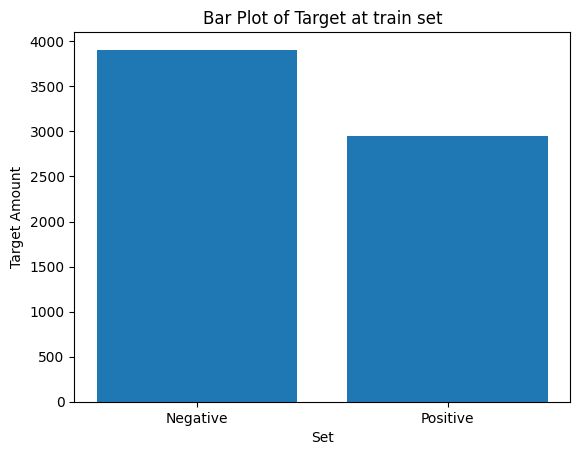

In [6]:
kind_of_set = ['Negative', 'Positive']
amount_of_target = [number_of_negative_target_at_train, number_of_positive_target_at_train]

plt.bar(kind_of_set, amount_of_target)
plt.title('Bar Plot of Target at train set')
plt.xlabel('Set')
plt.ylabel('Target Amount')
plt.show()

### Δημιουργία Bar Plot για test set

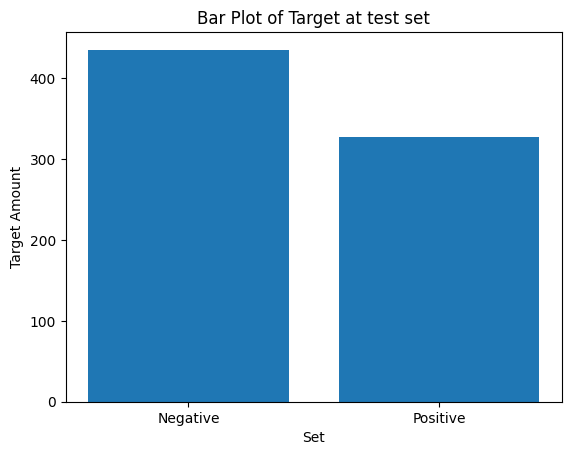

In [7]:
kind_of_set = ['Negative', 'Positive']
amount_of_target = [number_of_negative_target_at_test, number_of_positive_target_at_test]

plt.bar(kind_of_set, amount_of_target)
plt.title('Bar Plot of Target at test set')
plt.xlabel('Set')
plt.ylabel('Target Amount')
plt.show()

### Εύρεση Ποσοστού

In [8]:
total_amount_of_positive_target= number_of_positive_target_at_train + number_of_positive_target_at_test
total_amount_of_target= len(df_target)

percent_of_positive_targets= round(total_amount_of_positive_target/total_amount_of_target, 2)
percent_of_negative_targets= round(1-percent_of_positive_targets, 2)

print("Percentage of positive targets at the dataset: ", percent_of_positive_targets)
print("Percentage of negative targets at the dataset: ", percent_of_negative_targets)

Percentage of positive targets at the dataset:  0.43
Percentage of negative targets at the dataset:  0.57


Το dataset δεν μπορεί να χαρακτηριστεί ως απολύτως ισορροπημένο. Ωστόσο η κατανομή των κλάσεων (57% αρνητικά–43% θετικά) δεν υποδηλώνει κάποια σημαντική ανισορροπία.

## Δεύτερο Ερώτημα

### Αφαίρεση των χαρακτηριστικών id και location

In [9]:
x_train= x_train.drop(columns= ["id", "location"])
x_train['keyword'] = x_train['keyword'].fillna("null")
x_train['inputs']= x_train['keyword'] + " " + x_train['text']
x_train= x_train.drop(columns= ["keyword", "text"])

x_test= x_test.drop(columns= ["id", "location"])
x_test['keyword'] = x_test['keyword'].fillna("null")
x_test['inputs']= x_test['keyword'] + " " + x_test['text']
x_test= x_test.drop(columns= ["keyword", "text"])

## Τρίτο Ερώτημα

Οι συναρτήσεις που χρησιμοποιήθηκαν έχουν να κάνουν σχετικά με:
1. <u>Αφαίρεση των #</u>: Αφαιρέθηκε το σύμβολο # ώστε να διατηρηθεί μόνο η σημαντική πληροφορία (για παράδειγμα disaster αντί για #disaster) αυξάνοντας έτσι την πιθανότητα σωστής ταξινόμησης του γεγονότος
2. <u>Διατήρηση μόνο των χαρατκήρων ASCII</u>: Μειώνεται ο θόρυβος της περιττής πληροφορίας
3. <u>Διαγραφή όλων των αριθμών</u>: Δεν προσφέρουν πληροφορία για την ταξινόμηση ενός γεγονότος ως επικίνδυνη
4. <u>Διαγραφή των url και αντικατάσταση με το string 'url'</u>: Τα url δεν μπορούν να παρέχουν από μόνα τους κάποια πληροφορία
5. <u>Μετατροπή όλων των @user σε "atUser"</u>: Το ποιος έγραψε το κείμενο δεν παρέχει πληροφορία για το αν η φυσική καταστροφή βρίσκεται πραγματικά σε εξέλιξη

In [10]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeNumbers(text):
    """ Removes integers """
    text = ''.join([i for i in text if not i.isdigit()])
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\.'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1878827171.py:19: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
/tmp/ipython-input-1878827171.py:25: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('@[^\s]+','atUser',text)


In [11]:
for i in range(len(x_train)):
    text = x_train['inputs'].iloc[i]
    text = removeUnicode(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = removeNumbers(text)
    x_train.iloc[i, 0] = text

x_train

,inputs
6669,threat Meek Mill responds to Drakes OVO Fest s...
3940,flood survived the plague\nfloated the flood\n...
7217,weapons Kick Hendrixonfire atUser | BIG NOOB ...
2234,deluge Vince McMahon once again a billionaire:...
4233,hazardous Is it possible to sneak into a hospi...
...,...
3865,flames atUser want to burst into flames! *Anna...
6854,trauma Photo: lavenderpoetrycafe: The Forgotte...
5669,rescue Officials rescue migrants off Libya; ...
3397,explode If Ryan doesn't release new music soon...


In [12]:
for i in range(len(x_test)):
    text = x_test['inputs'].iloc[i]
    text = removeUnicode(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = removeNumbers(text)
    x_test.iloc[i, 0] = text

x_test

,inputs
604,bioterror FedEx no longer to transport bioterr...
5374,panic Panic over: Patient in Alabama tests neg...
3022,dust%storm New Mad Max Screenshots Show Off a ...
3357,evacuated Rocky fire in Northern California sw...
4726,lava atUser Lava Blast &amp; Power Red atUser ...
...,...
5098,nuclear%disaster refugees of nuclear disaster ...
525,avalanche Musician Kalle Mattson Recreates Cl...
5169,obliterate atUser good sir I did not wish to b...
3592,fatal Man charged over fatal crash near Dubbo ...


## Τέταρτο Ερώτημα

### Χωρισμός Δεδομένων σε inputs και targets με χρήση numpy arrays

In [13]:
inputs_train= x_train['inputs'].to_numpy()
targets_train= y_train.to_numpy()

inputs_test= x_test['inputs'].to_numpy()
targets_test= y_test.to_numpy()

inputs_train.shape, targets_train.shape, inputs_test.shape, targets_test.shape

((6851,), (6851,), (762,), (762,))

## Πέμπτο Ερώτημα

In [14]:
vectorizer= TfidfVectorizer()

inputs_train= vectorizer.fit_transform(inputs_train)
inputs_test= vectorizer.transform(inputs_test)

inputs_train.shape, inputs_test.shape

((6851, 13486), (762, 13486))

## Έκτο Ερώτημα

In [15]:
model= LinearSVC()
model.fit(inputs_train, targets_train)

y_pred_at_train= model.predict(inputs_train)
accuray_at_train= accuracy_score(targets_train, y_pred_at_train)
f1_score_at_train= f1_score(targets_train, y_pred_at_train)
precision_score_at_train= precision_score(targets_train, y_pred_at_train)
recall_score_at_train= recall_score(targets_train, y_pred_at_train)

y_pred_at_test= model.predict(inputs_test)
accuray_at_test= accuracy_score(targets_test, y_pred_at_test)
f1_score_at_test= f1_score(targets_test, y_pred_at_test)
precision_score_at_test= precision_score(targets_test, y_pred_at_test)
recall_score_at_test= recall_score(targets_test, y_pred_at_test)

print("For the train set:")
print("accuracy: ", accuray_at_train)
print("f1 score: ", f1_score_at_train)
print("precision score: ", precision_score_at_train)
print("recall score: ", recall_score_at_train)
print()
print("For the test set:")
print("accuracy: ", accuray_at_test)
print("f1 score: ", f1_score_at_test)
print("precision score: ", precision_score_at_test)
print("recall score: ", recall_score_at_test)

metrics_of_linSVC_train = [accuray_at_train, f1_score_at_train, precision_score_at_train, recall_score_at_train]
metrics_of_linSVC_test = [accuray_at_test, f1_score_at_test, precision_score_at_test, recall_score_at_test]

For the train set:
accuracy:  0.961465479492045
f1 score:  0.9541507467870789
precision score:  0.9761904761904762
recall score:  0.9330842391304348

For the test set:
accuracy:  0.800524934383202
f1 score:  0.7602523659305994
precision score:  0.7850162866449512
recall score:  0.7370030581039755


Πιο σημαντική μετρική είναι το recall, καθώς πρέπει το μοντέλο να προβλέπει όσο το δυνατό περισσότερες θετικές περιπτώσεις. Πρόκειται για ένα σύστημα το οποίο πρέπει να δίνει προτεραιότητα στο να μην χαθεί κανένα πραγματικό περιστατικό.

## Έβδομο Ερώτημα

### Μετασχηματισμός στα δεδομένα με χρήση PCA

In [16]:
#data for the Bayes question
bayes_inputs_train= inputs_train
bayes_inputs_test= inputs_test


inputs_train= inputs_train.toarray()
inputs_test= inputs_test.toarray()

pca = PCA(n_components=0.95, random_state= 0)
inputs_train= pca.fit_transform(inputs_train)
inputs_test= pca.transform(inputs_test)

inputs_train.shape, inputs_test.shape

((6851, 3728), (762, 3728))

### Εκπαίδευση LinearSVC

In [17]:
model= LinearSVC()
model.fit(inputs_train, targets_train)

y_pred_at_train= model.predict(inputs_train)
accuray_at_train= accuracy_score(targets_train, y_pred_at_train)
f1_score_at_train= f1_score(targets_train, y_pred_at_train)
precision_score_at_train= precision_score(targets_train, y_pred_at_train)
recall_score_at_train= recall_score(targets_train, y_pred_at_train)

y_pred_at_test= model.predict(inputs_test)
accuray_at_test= accuracy_score(targets_test, y_pred_at_test)
f1_score_at_test= f1_score(targets_test, y_pred_at_test)
precision_score_at_test= precision_score(targets_test, y_pred_at_test)
recall_score_at_test= recall_score(targets_test, y_pred_at_test)

print("For the train set:")
print("accuracy: ", accuray_at_train)
print("f1 score: ", f1_score_at_train)
print("precision score: ", precision_score_at_train)
print("recall score: ", recall_score_at_train)
print()
print("For the test set:")
print("accuracy: ", accuray_at_test)
print("f1 score: ", f1_score_at_test)
print("precision score: ", precision_score_at_test)
print("recall score: ", recall_score_at_test)

metrics_of_linSVC2_train = [accuray_at_train, f1_score_at_train, precision_score_at_train, recall_score_at_train]
metrics_of_linSVC2_test = [accuray_at_test, f1_score_at_test, precision_score_at_test, recall_score_at_test]

For the train set:
accuracy:  0.9372354400817399
f1 score:  0.924667133847232
precision score:  0.9547756874095513
recall score:  0.8963994565217391

For the test set:
accuracy:  0.8097112860892388
f1 score:  0.7716535433070866
precision score:  0.7954545454545454
recall score:  0.7492354740061162


### Εκπαίδευση SVC

In [18]:
model= SVC(kernel='rbf')
model.fit(inputs_train, targets_train)

y_pred_at_train= model.predict(inputs_train)
accuray_at_train= accuracy_score(targets_train, y_pred_at_train)
f1_score_at_train= f1_score(targets_train, y_pred_at_train)
precision_score_at_train= precision_score(targets_train, y_pred_at_train)
recall_score_at_train= recall_score(targets_train, y_pred_at_train)

y_pred_at_test= model.predict(inputs_test)
accuray_at_test= accuracy_score(targets_test, y_pred_at_test)
f1_score_at_test= f1_score(targets_test, y_pred_at_test)
precision_score_at_test= precision_score(targets_test, y_pred_at_test)
recall_score_at_test= recall_score(targets_test, y_pred_at_test)

print("For the train set:")
print("accuracy: ", accuray_at_train)
print("f1 score: ", f1_score_at_train)
print("precision score: ", precision_score_at_train)
print("recall score: ", recall_score_at_train)
print()
print("For the test set:")
print("accuracy: ", accuray_at_test)
print("f1 score: ", f1_score_at_test)
print("precision score: ", precision_score_at_test)
print("recall score: ", recall_score_at_test)

metrics_of_SVC_train = [accuray_at_train, f1_score_at_train, precision_score_at_train, recall_score_at_train]
metrics_of_SVC_test = [accuray_at_test, f1_score_at_test, precision_score_at_test, recall_score_at_test]

For the train set:
accuracy:  0.9442417165377317
f1 score:  0.9324611032531824
precision score:  0.9723451327433629
recall score:  0.8957201086956522

For the test set:
accuracy:  0.8162729658792651
f1 score:  0.7784810126582279
precision score:  0.8065573770491803
recall score:  0.7522935779816514


## Όγδοο Ερώτημα

* Για scale η τιμή της παραμέτρου γ είναι ίση με:<br> **γ = 1 / (n_features * X.var())**
* Για auto η τιμή της παραμέτρου γ είναι ίση με : <br> **γ = 1 / n_features**

### Εκπαίδευση SVC με γ= "auto"

In [19]:
model= SVC(kernel='rbf', gamma= "auto")
model.fit(inputs_train, targets_train)

y_pred_at_train= model.predict(inputs_train)
accuray_at_train= accuracy_score(targets_train, y_pred_at_train)
f1_score_at_train= f1_score(targets_train, y_pred_at_train)
precision_score_at_train= precision_score(targets_train, y_pred_at_train, zero_division = 0)
recall_score_at_train= recall_score(targets_train, y_pred_at_train)

y_pred_at_test= model.predict(inputs_test)
accuray_at_test= accuracy_score(targets_test, y_pred_at_test)
f1_score_at_test= f1_score(targets_test, y_pred_at_test)
precision_score_at_test= precision_score(targets_test, y_pred_at_test, zero_division = 0)
recall_score_at_test= recall_score(targets_test, y_pred_at_test)

print("For the train set:")
print("accuracy: ", accuray_at_train)
print("f1 score: ", f1_score_at_train)
print("precision score: ", precision_score_at_train)
print("recall score: ", recall_score_at_train)
print()
print("For the test set:")
print("accuracy: ", accuray_at_test)
print("f1 score: ", f1_score_at_test)
print("precision score: ", precision_score_at_test)
print("recall score: ", recall_score_at_test)

metrics_of_SVC2_train = [accuray_at_train, f1_score_at_train, precision_score_at_train, recall_score_at_train]
metrics_of_SVC2_test = [accuray_at_test, f1_score_at_test, precision_score_at_test, recall_score_at_test]

For the train set:
accuracy:  0.570281710699168
f1 score:  0.0
precision score:  0.0
recall score:  0.0

For the test set:
accuracy:  0.5708661417322834
f1 score:  0.0
precision score:  0.0
recall score:  0.0


### Δημιουργία Bar-Plot για τα μοντέλα

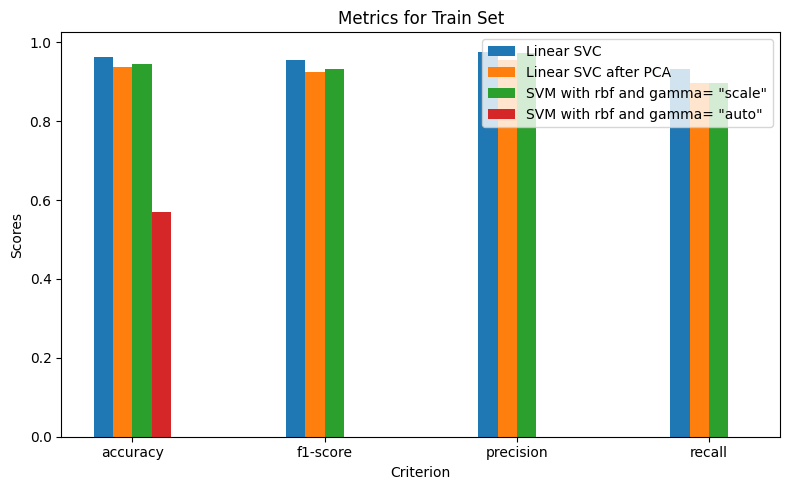

In [24]:
labels= ['accuracy', 'f1-score', 'precision', 'recall']
x = np.arange(4)
width = 0.1

plt.figure(figsize=(8, 5))

plt.bar(x - 1.5*width, metrics_of_linSVC_train, width, label='Linear SVC')
plt.bar(x - 0.5*width, metrics_of_linSVC2_train, width, label='Linear SVC after PCA')
plt.bar(x + 0.5*width, metrics_of_SVC_train, width, label='SVM with rbf and gamma= "scale"')
plt.bar(x + 1.5*width, metrics_of_SVC2_train, width, label='SVM with rbf and gamma= "auto"')

plt.xticks(x, labels)
plt.title('Metrics for Train Set')
plt.ylabel('Scores')
plt.xlabel('Criterion')
plt.legend()

plt.tight_layout()
plt.show()

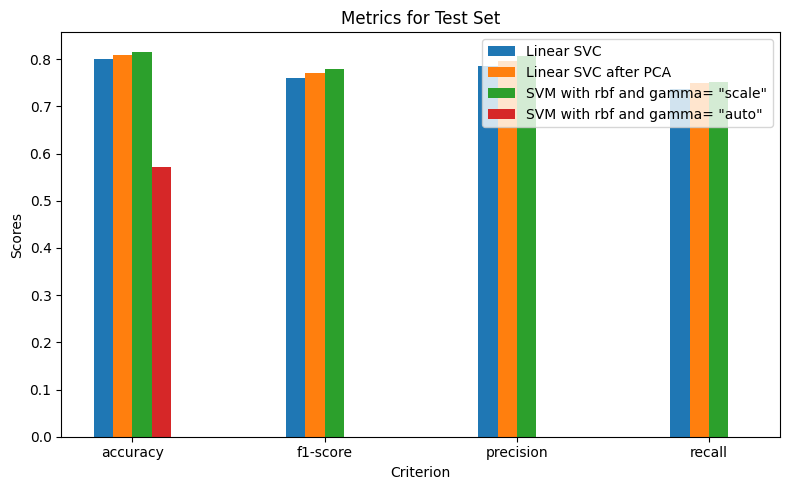

In [25]:
labels= ['accuracy', 'f1-score', 'precision', 'recall']
x = np.arange(4)
width = 0.1

plt.figure(figsize=(8, 5))

plt.bar(x - 1.5*width, metrics_of_linSVC_test, width, label='Linear SVC')
plt.bar(x - 0.5*width, metrics_of_linSVC2_test, width, label='Linear SVC after PCA')
plt.bar(x + 0.5*width, metrics_of_SVC_test, width, label='SVM with rbf and gamma= "scale"')
plt.bar(x + 1.5*width, metrics_of_SVC2_test, width, label='SVM with rbf and gamma= "auto"')

plt.xticks(x, labels)
plt.title('Metrics for Test Set')
plt.ylabel('Scores')
plt.xlabel('Criterion')
plt.legend()

plt.tight_layout()
plt.show()

## Ένατο Ερώτημα

In [22]:
bayes_inputs_train= bayes_inputs_train.toarray()
bayes_inputs_test= bayes_inputs_test.toarray()

model= GaussianNB()
model.fit(bayes_inputs_train, targets_train)

y_pred_at_train= model.predict(bayes_inputs_train)
accuray_at_train= accuracy_score(targets_train, y_pred_at_train)
f1_score_at_train= f1_score(targets_train, y_pred_at_train)
precision_score_at_train= precision_score(targets_train, y_pred_at_train, zero_division = 0)
recall_score_at_train= recall_score(targets_train, y_pred_at_train)

y_pred_at_test= model.predict(bayes_inputs_test)
accuray_at_test= accuracy_score(targets_test, y_pred_at_test)
f1_score_at_test= f1_score(targets_test, y_pred_at_test)
precision_score_at_test= precision_score(targets_test, y_pred_at_test, zero_division = 0)
recall_score_at_test= recall_score(targets_test, y_pred_at_test)

print("For the train set:")
print("accuracy: ", accuray_at_train)
print("f1 score: ", f1_score_at_train)
print("precision score: ", precision_score_at_train)
print("recall score: ", recall_score_at_train)
print()
print("For the test set:")
print("accuracy: ", accuray_at_test)
print("f1 score: ", f1_score_at_test)
print("precision score: ", precision_score_at_test)
print("recall score: ", recall_score_at_test)

For the train set:
accuracy:  0.879141731134141
f1 score:  0.8767123287671232
precision score:  0.7804878048780488
recall score:  1.0

For the test set:
accuracy:  0.6207349081364829
f1 score:  0.6445264452644527
precision score:  0.5390946502057613
recall score:  0.8012232415902141
